# Visualizing KJM digit flexion ECoG results

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')

%matplotlib inline

# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

import neurodsp as ndsp
from scv_funcs import lfpca
from scv_funcs import utils

In [3]:
def plot_bandpower_contrast(lfpca_all, plot_chan, sum_freqs_lims=(70,90)):
    sum_freqs = range(sum_freqs_lims[0],sum_freqs_lims[1])
    band_power = [np.log10(lf.spg[plot_chan, sum_freqs,:]).mean(axis=0) for lf in lfpca_all]
    plt.loglog(band_power[0], band_power[1], '.')
    unity = [np.min([plt.xlim()[0],plt.ylim()[0]]),np.max([plt.xlim()[1],plt.ylim()[1]])]
    plt.loglog(unity,unity,'k--')
    plt.xlabel('Pre Power')
    plt.ylabel('Move Power')
    plt.title('Chan:%i, %.1f-%.1fHz'%(plot_chan,lfpca_all[0].f_axis[sum_freqs[0]],lfpca_all[0].f_axis[sum_freqs[-1]]))
    rho,pv = sp.stats.spearmanr(band_power[0],band_power[1])
    print('Spearman: %.5f, p=%.5f'%(rho,pv))

In [4]:
# define data folder
data_path = '/Users/rdgao/Documents/data/ECoG_KJM/digit/'
saveout_path = '../results/kjm_digits/'
save_files = ['pre','move','whole']
subjs = ['bp', 'cc', 'ht', 'jc', 'jp', 'mv', 'wc', 'wm', 'zt']

# electrode location
elec_def = {
    '1': 'dorsal M1',
    '3': 'dorsal S1',
    '4': 'ventral S1+M1',
    '6': 'frontal (non-R)',
    '7': 'parietal (non-R)',
    '8': 'temporal',
    '9': 'occipital'
}
fs = 1000.
labels = [f for f in save_files]

# visualizing SCV/Exponential fitness during resting vs. movement states

In [5]:
comp_merged = False
# querying a specific subject
subj = subjs[0]
subj_path = saveout_path+subj+'/'
lfpca_all = []
for cond in save_files:
    lfpca_all.append(lfpca.lfpca_load_spec(subj_path+cond+'.npz'))

trial_data = np.load(subj_path+'trial_info.npz')
trial_info = trial_data['trial_info']
elec_regions = trial_data['elec_regions']

if comp_merged:
    # get lfpca for pre+move merged
    lfpca_all.append(lfpca.LFPCA(lfpca_all[0].return_params()))
    lfpca_all[-1].populate_fourier_data(np.concatenate((lfpca_all[0].spg,lfpca_all[1].spg),axis=-1), fs, lfpca_all[0].f_axis)
    lfpca_all[-1].compute_psd()
    lfpca_all[-1].compute_scv()
    lfpca_all[-1].compute_KS_expfit()
    labels.append('merged')

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


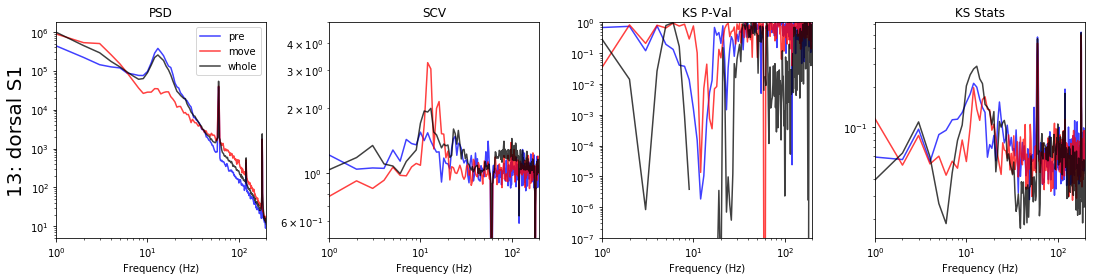

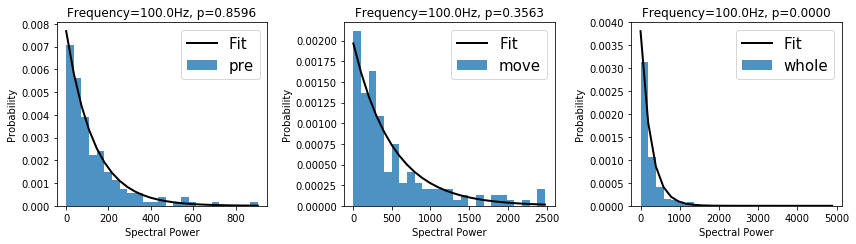

In [7]:
plot_chan = 13
plot_freq = 100
plot_colors = ['b','r','k']
plt.figure(figsize=(15,4))
for ind, lf in enumerate(lfpca_all):
    lf.plot_spectral(plot_mean=False, plot_chan=plot_chan, plot_color=plot_colors[ind])
plt.subplot(1,4,1)
plt.ylabel('%i: '%plot_chan+elec_def[elec_regions[plot_chan].astype(str)], fontsize=20)
plt.legend(labels)

plt.figure(figsize=(12,3.5))
for ind, lf in enumerate(lfpca_all):
    plt.subplot(1,3,ind+1)
    lf.plot_expfit(plot_chan, freq_ind=plot_freq, num_bins=25)
    plt.legend(('Fit',labels[ind]), fontsize=15)
plt.tight_layout()

### observation: movement increases noise-amplitude
- For a few of the channels (BP12-14), there is a clear increase in high-gamma/broadband frequencies (60-100Hz). However, within either conditions, power is distributed exponentially across trials, which means each trial is an (more or less) independent draw from the distribution, and the two distributions differ in mean.
- similarly, low-frequency power (<10Hz) on some channels (e.g. BP12) is also distributed exponentially in both conditions, but not merged

Spearman: 0.08523, p=0.30303
Spearman: 0.04000, p=0.62930
Spearman: 0.08083, p=0.32875


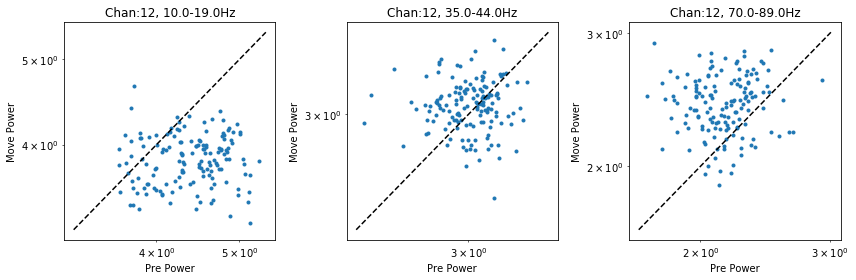

In [17]:
plot_chan = 12#13
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plot_bandpower_contrast(lfpca_all, plot_chan, (10,20))
plt.subplot(1,3,2)
plot_bandpower_contrast(lfpca_all, plot_chan, (35,45))
plt.subplot(1,3,3)
plot_bandpower_contrast(lfpca_all, plot_chan, (70,90))
plt.tight_layout()

### observation: pre and movement period broadband power is uncorrelated
- very surprisingly, bb power is not correlated between pre and movement periods, further supporting the notion that bb power may be, effectively, random draws from two exponential distributions with different means, even though movement consistently increases bb power
- low-frequency (oscillatory) power is ALSO uncorrelated, neither is noise frequency power? But movement decreases beta power, as expected, while does not change midrange power

### to do:
- investigate if this is the case in a time-resolved manner, i.e. BB power over time within a single trial is distributed via exponential distribution